## 모델 학습하기
철헌님 코드 활용하였습니다.

In [15]:
# import konlpy and other libraries to analyse Korean text data
from konlpy.tag import Kkma

# create an instance of Kkma and Okt
kkma = Kkma()

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split



from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding, Dense, Dropout, Conv1D, GlobalMaxPooling1D, BatchNormalization

from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

from gensim.models import Word2Vec
from konlpy.tag import Okt

import pickle
from tensorflow.keras.optimizers import Adam

In [17]:
train_data = pd.read_csv(os.getcwd() + '/sns_syn_sent_augment.csv')

#### 이미 전처리해서 중복 등을 제거한 좋은 데이터로 시작
각 클래스는 정수인코딩 되어있고   
협박 대화 = 0,  
갈취 대화 = 1,  
직장 내 괴롭힘 대화 = 2,  
기타 괴롭힘 대화 = 3,  
일반 = 4   

In [18]:
train_data

,conversation,class
0,선택권이 것인가 너가 네 . 거면 죽여버려야겠군 정말 죽여달라고 혼자 . ? . 선...,0
1,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...,0
2,지금 너 애원하는 것인가 아닙니다 . 죄송합니다 . 죽을 혼자 죽지 우리까지 사건에...,0
3,장난전화는 진정하세요 얘기한다 너에게 달려있다 장난전화 재미있겠지 더 터지면 선생님...,0
4,길동경찰서입니다 . 시 분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 한번만...,0
...,...,...
45673,슈룹 시청률 머박! 렬루다가? 치솟았어 어디서 봤어? tvN에서 방영 중이야 시청률...,4
45674,슈룹 시청률 머박! 렬루다가? 어디서 봤어? tvN에서 방영 중이야 시청률이 되는데...,4
45675,도와서 기대해볼게 힐링되면서도 마음 안녕! 봤어 한번 방송이라 얘기하자 가! 의뢰인...,4
45676,이상한 변호사 우영우 너무 재밌어! 응! 나도 매주 기다려! 어제 방송 어땠어? 오...,4


In [19]:
# 레코드를 일부만 가져오기
data_skipped_2 = train_data[train_data.index % 2 == 0] # 22839개 레코드
data_skipped_2

,conversation,class
0,선택권이 것인가 너가 네 . 거면 죽여버려야겠군 정말 죽여달라고 혼자 . ? . 선...,0
2,지금 너 애원하는 것인가 아닙니다 . 죄송합니다 . 죽을 혼자 죽지 우리까지 사건에...,0
4,길동경찰서입니다 . 시 분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 한번만...,0
6,놀리는거 장가가고하던데 너도 도 작은데 그거 . 안돼는거네 너 . ? 군대도 너 그...,3
8,너 귀여운거 알지 ? 나보다 작은 첨봤어 . 그만해 니들 재미없어 . 너가 키 이지...,3
...,...,...
45668,스물다섯 봤어? 응 너무 김태리랑 남주혁 케미 진짜 좋았지? 너무 이쁘고 쩔더라 그...,4
45670,빅마우스 드라마 볼래? 나는 드라마 잘 안 봐 레알? 빅마우스는 굉장히 흥미로운 내...,4
45672,추천해줘서 슈룹은 복수 김혜수 안녕! 14.8%에서 재밌게 중이야 레게노다 별말씀을...,4
45674,슈룹 시청률 머박! 렬루다가? 어디서 봤어? tvN에서 방영 중이야 시청률이 되는데...,4


#### 한국어 형태소 분석 후 word2vec

In [20]:
# 클래스별 가장 많이 쓰이는 토큰이 저장됨

token_data = pd.read_csv(os.getcwd()  + '/most-common-tokens.csv')
token_data.head(10)

,class0_most_common,class1_most_common,class2_most_common,class3_most_common,class4_most_common
0,어,.,.,.,어
1,.,어,하,어,하
2,하,?,?,?,!
3,?,이,이,하,이
4,이,아,어,아,?
5,아,하,아,이,아
6,는,고,는,는,는
7,가,가,가,가,.
8,고,는,고,야,ㄴ
9,!,돈,ㄴ,고,가


In [21]:
# 가장 많이 쓰이는 클래스별 50개의 단어를 추출하여 중복을 제거한 후, 총 단어의 개수를 출력
top_50_tokens = [item for sublist in token_data[:50].values.tolist() for item in sublist]

# 불용어 만들기
# 중복 제거
stopwords = list(set(top_50_tokens))
print(len(stopwords))
print(stopwords)

79
['겠', '네', '.', '왜', '느', '요', '여', '세요', '가', '이', '어요', '아', '그러', '없', '자', '수', '있', '는데', '았', '?', '게', '되', 'ㄹ까', '어야', '저', '었', '시', '아니', '것', '고', '나', '면', '야', 'ㄹ', '짜', '에', '일', '뭐', '도', '죄송', '하', '보', '안', '를', '니', '좋', '냐', '어', '습니다', '말', '알', '주', '지', '돈', '그', '는', '너', '그리하', '다', '어서', '에서', 'ㄴ', '만', '오', '거', '죽', '맞', '같', '좀', '로', '님', '들', '!', '내', '은', '을', '씨', 'ㅂ니다', '응']


In [22]:
tokenized_data = [kkma.morphs(sentence) for sentence in data_skipped_2['conversation']]

In [41]:

tokenized_data_without_stopwords = []
for sentence in tokenized_data:
    sentence_without_stopwords = [token for token in sentence if token not in stopwords]
    tokenized_data_without_stopwords.append(sentence_without_stopwords)
len(tokenized_data_without_stopwords)

22839

In [42]:
embedding_model = Word2Vec(sentences=tokenized_data_without_stopwords,
							sg = 1,
                            vector_size = 512,
                            window = 10,
                            min_count = 1,
                            workers = 4)

In [43]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(tokenized_data_without_stopwords)
train_X = tokenizer.texts_to_sequences(tokenized_data_without_stopwords)

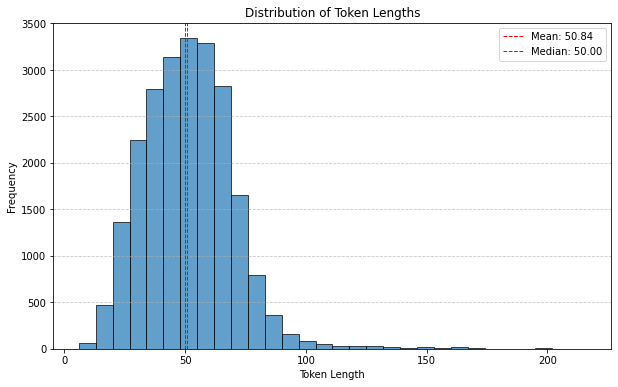

79.0


In [44]:
# Compute token lengths
token_lengths = [len(seq) for seq in train_X]

# Compute statistics
mean_length = np.mean(token_lengths)
std_length = np.std(token_lengths)
min_length = np.min(token_lengths)
max_length = np.max(token_lengths)
median_length = np.median(token_lengths)

# Create a DataFrame for statistics
stats_df = pd.DataFrame({
    "Statistic": ["Mean", "Standard Deviation", "Min", "Max", "Median"],
    "Value": [mean_length, std_length, min_length, max_length, median_length]
})

# Plot histogram of token lengths
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_length:.2f}')
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of Token Lengths")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(np.percentile(token_lengths, 95))


In [45]:
vocab_size=50000
embedding_dim=256
max_len = 150 # 평균 + 1.5 * 표준편차 한 것

train_X = tokenizer.texts_to_sequences(tokenized_data)
train_X = pad_sequences(train_X, maxlen=max_len, padding='pre')
train_y = data_skipped_2['class'].values

In [46]:
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

In [47]:
print(f"training data size: {len(train_X)}")
print(f"validation data size: {len(val_X)}")

training data size: 18271
validation data size: 4568


### 스태킹 앙상블 기법을 활용하기 위해 kernel_size와 dropout rate이 다른 세 모델 형성

In [652]:
def textcnn_model(kernel_size, dropout):
    model = Sequential()

    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(Conv1D(256, kernel_size=kernel_size, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [653]:
#### 모델 3개 생성
TextCNN1 = textcnn_model(kernel_size=3, dropout=0.2)
TextCNN2 = textcnn_model(kernel_size=4, dropout=0.2)
TextCNN3 = textcnn_model(kernel_size=5, dropout=0.2)

# callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


# epochs
NUM_EPOCHS = 30


# 모델 학습
history1 = TextCNN1.fit(train_X, train_y,
                        batch_size = 256,
                        epochs = NUM_EPOCHS,
                        validation_data = (val_X, val_y),
                        callbacks=[es, lr]
                       )

history2 = TextCNN2.fit(train_X, train_y,
                        batch_size = 256,
                        epochs = NUM_EPOCHS,
                        validation_data = (val_X, val_y),
                        callbacks=[es, lr]
                       )

history3 = TextCNN3.fit(train_X, train_y,
                        batch_size = 256,
                        epochs = NUM_EPOCHS,
                        validation_data = (val_X, val_y),
                        callbacks=[es, lr]
                       )


Epoch 1/30
72/72 [==============================] - 4s 50ms/step - loss: 2.7837 - accuracy: 0.7581 - val_loss: 3.1169 - val_accuracy: 0.1020
Epoch 2/30
72/72 [==============================] - 2s 34ms/step - loss: 1.4141 - accuracy: 0.9732 - val_loss: 2.6919 - val_accuracy: 0.0749
Epoch 3/30
72/72 [==============================] - 2s 34ms/step - loss: 0.7903 - accuracy: 0.9967 - val_loss: 1.8952 - val_accuracy: 0.7653
Epoch 4/30
72/72 [==============================] - 2s 34ms/step - loss: 0.4377 - accuracy: 0.9987 - val_loss: 1.1626 - val_accuracy: 0.7704
Epoch 5/30
72/72 [==============================] - 2s 34ms/step - loss: 0.2739 - accuracy: 0.9943 - val_loss: 0.8691 - val_accuracy: 0.7476
Epoch 6/30
72/72 [==============================] - 2s 34ms/step - loss: 0.2633 - accuracy: 0.9843 - val_loss: 0.6549 - val_accuracy: 0.8089
Epoch 7/30
72/72 [==============================] - 2s 34ms/step - loss: 0.2066 - accuracy: 0.9916 - val_loss: 0.4270 - val_accuracy: 0.9059
Epoch 8/30
72

In [654]:
pred_train1 = TextCNN1.predict(train_X)
pred_train2 = TextCNN2.predict(train_X)
pred_train3 = TextCNN3.predict(train_X)
meta_train = np.concatenate([pred_train1, pred_train2, pred_train3], axis=1)

pred_val1 = TextCNN1.predict(val_X)
pred_val2 = TextCNN2.predict(val_X)
pred_val3 = TextCNN3.predict(val_X)
meta_val = np.concatenate([pred_val1, pred_val2, pred_val3], axis=1)

In [655]:
print(meta_train[:1])
print(meta_train.shape[1])
print(train_y[:1])

[[4.9162438e-05 6.0824103e-05 7.4321783e-06 9.9988258e-01 2.5624182e-11
  1.6452441e-05 3.7929928e-04 9.3558219e-06 9.9959463e-01 2.8339051e-07
  9.1853517e-04 7.2748685e-04 9.9884637e-04 9.9725312e-01 1.0199602e-04]]
15
[3]


In [656]:
# 메타 모델
meta_model = Sequential()

meta_model.add(Dense(128, activation='gelu', input_shape=(15,), kernel_regularizer=regularizers.l2(0.01)))
meta_model.add(BatchNormalization())
meta_model.add(Dropout(0.4))
meta_model.add(Dense(128, activation='gelu', kernel_regularizer=regularizers.l2(0.01)))
meta_model.add(BatchNormalization())
meta_model.add(Dropout(0.4))
meta_model.add(Dense(128, activation='gelu', kernel_regularizer=regularizers.l2(0.01)))
meta_model.add(BatchNormalization())
meta_model.add(Dropout(0.4))
meta_model.add(Dense(5, activation='softmax'))

meta_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Stacking 학습
meta_model.fit(meta_train, train_y,
               validation_data=(meta_val, val_y),
               epochs=20,
               batch_size=128,
               callbacks=[es, lr]
              )


Epoch 1/20
143/143 [==============================] - 2s 6ms/step - loss: 2.3066 - accuracy: 0.9507 - val_loss: 1.9460 - val_accuracy: 0.7454
Epoch 2/20
143/143 [==============================] - 1s 5ms/step - loss: 0.8310 - accuracy: 0.9988 - val_loss: 1.0477 - val_accuracy: 0.7454
Epoch 3/20
143/143 [==============================] - 1s 5ms/step - loss: 0.2655 - accuracy: 0.9997 - val_loss: 0.8118 - val_accuracy: 0.8382
Epoch 4/20
143/143 [==============================] - 1s 5ms/step - loss: 0.0911 - accuracy: 0.9996 - val_loss: 0.4459 - val_accuracy: 0.9709
Epoch 5/20
143/143 [==============================] - 1s 5ms/step - loss: 0.0504 - accuracy: 0.9993 - val_loss: 0.1374 - val_accuracy: 0.9735
Epoch 6/20
143/143 [==============================] - 1s 5ms/step - loss: 0.0232 - accuracy: 0.9997 - val_loss: 0.5958 - val_accuracy: 0.9560
Epoch 7/20
143/143 [==============================] - 1s 5ms/step - loss: 0.0350 - accuracy: 0.9990 - val_loss: 0.1467 - val_accuracy: 0.9733


In [657]:
# 검증 데이터 예측
val_preds = meta_model.predict(meta_val)
val_preds_classes = np.argmax(val_preds, axis=1)


In [658]:
from sklearn.metrics import f1_score

f1 = f1_score(val_y, val_preds_classes, average="weighted")  # weighted F1-score
print(f"Weighted F1-score: {f1:.4f}")

Weighted F1-score: 0.9735


In [659]:
report = classification_report(val_y, val_preds_classes, target_names=[f"Class {i}" for i in range(5)])
print(report)

              precision    recall  f1-score   support

     Class 0       0.91      0.88      0.89       260
     Class 1       0.86      0.90      0.88       271
     Class 2       0.93      0.97      0.95       290
     Class 3       0.91      0.88      0.89       342
     Class 4       1.00      1.00      1.00      3405

    accuracy                           0.97      4568
   macro avg       0.92      0.92      0.92      4568
weighted avg       0.97      0.97      0.97      4568



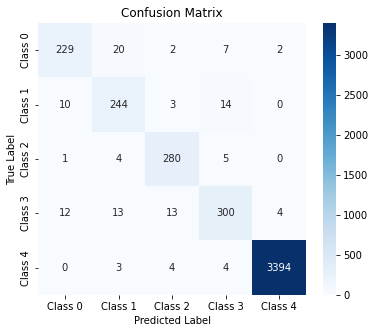

In [660]:
# Confusion Matrix 계산
cm = confusion_matrix(val_y, val_preds_classes)

# Confusion Matrix 시각화
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f"Class {i}" for i in range(5)], yticklabels=[f"Class {i}" for i in range(5)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [661]:
# val_y의 각 클래스 개수 출력
unique_classes, class_counts = np.unique(val_y, return_counts=True)

# 결과 출력
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count}개")


Class 0: 260개
Class 1: 271개
Class 2: 290개
Class 3: 342개
Class 4: 3405개


In [662]:
test_df = pd.read_csv(os.getcwd() + '/test.csv')

In [663]:
test_texts = test_df['text'].tolist()  # 테스트 데이터의 텍스트 추출
tokenized_test = [kkma.morphs(sentence) for sentence in test_texts]  # 형태소 분석 적용
test_X = tokenizer.texts_to_sequences(tokenized_test)  # 기존에 학습된 Tokenizer를 사용해 정수 인덱스로 변환
test_X = pad_sequences(test_X, maxlen=max_len, padding='pre')

print("Test 데이터 Shape:", len(test_X))  # (샘플 수, max_len)

Test 데이터 Shape: 500


In [664]:
pred_test1 = TextCNN1.predict(test_X)
pred_test2 = TextCNN2.predict(test_X)
pred_test3 = TextCNN3.predict(test_X)

meta_test = np.concatenate([pred_test1, pred_test2, pred_test3], axis=1)

In [665]:
test_pred = meta_model.predict(meta_test)

In [666]:
print(len(test_pred))

500


In [667]:
test_pred[0]

array([1.4905515e-03, 9.9646831e-01, 1.0341733e-03, 1.0015782e-03,
       5.3713688e-06], dtype=float32)

In [668]:
test_pred_labels = np.argmax(test_pred,axis=1)

In [669]:
test_pred_labels[:30]
# 각 클래스는 정수인코딩 되어있고
# 협박 대화 = 0,
# 갈취 대화 = 1,
# 직장 내 괴롭힘 대화 = 2,
# 기타 괴롭힘 대화 = 3,
# 일반 = 4

array([1, 2, 2, 3, 3, 0, 0, 3, 2, 1, 0, 3, 2, 2, 2, 0, 4, 3, 0, 3, 0, 3,
       3, 1, 1, 2, 3, 3, 2, 0])

In [670]:
def compare_label(pred):
    label30 = [1, 2, 4, 4, 3, 0, 0, 1, 4, 1, 0, 4, 2, 4, 2, 0, 4, 4, 0, 3, 0, 3, 3, 1, 1, 2, 4, 4, 2, 4]
    print(pred == label30)
    print()
compare_label(test_pred_labels[:30]) 

[ True  True False False  True  True  True False False  True  True False
  True False  True  True  True False  True  True  True  True  True  True
  True  True False False  True False]



In [671]:
# # 인덱스 열 생성 (t_000 ~ t_499)
idx_column = [f"t_{i:03d}" for i in range(len(test_pred_labels))]

# DataFrame 생성
submission_df = pd.DataFrame({
    "idx": idx_column,
    "target": test_pred_labels
})

# 확인
print(submission_df.head(10))  # 상위 10개 출력

# CSV로 저장
submission_df.to_csv(os.getcwd() + "submission_textcnn.csv", index=False)

print("CSV 저장 완료: submission_textcnn.csv")


In [672]:
# 클래스 개수 확인
class_distribution = pd.Series(submission_df['target']).value_counts().sort_index()
print(class_distribution)


0    104
1    112
2    124
3    126
4     34
Name: target, dtype: int64


하이퍼파라미터 계속 바꾸어가면서 학습 진행함.